# Fingerprints
The substructure keys we used in the last exercise are nice, but they are not without limitations. The main issue with them is that we have to manually define a set of substructures to observe. Not only it is a lot of work, but it also inherently reflects our own biases in feature selection.

An alternative approach is not to observe a given list of substructures, but go one layer of abstraction higher and observe all structural features of a defined type. For example, we can observe all atoms in the characterized molecule, their types, and how far they are in relation with each other. Alternatively, we can also observe the surroundings of each atom within the characterized molecule, up to 2 or 3 bonds distance. This is the basis of the ever-popular circular fingerprints (i.e. a "circle" with radius of 2 or 3 bonds around every atom), most notably the Extended Connectivity Fingerprints (ECFP). More information on ECFP fingerprints and their uses is in [ChemAxon docs](https://docs.chemaxon.com/display/docs/Extended+Connectivity+Fingerprint+ECFP) and [Daylight docs](https://www.daylight.com/dayhtml/doc/theory/theory.finger.html).

![ECFP_radii](../data/pix/ecfp_iterations.png)
![ECFP_generation](../data/pix/ecfp_generation.png)

As you can probably imagine, the amount of the observed features in such fingerprints is going to be very large. Combinatorially speaking, there are very many possible substructures of 4 to 6 bonds across, and every molecule is going to contain only a very small subset of those. The large number of observed features can be put into a more manageable size by using a [hash function](https://en.wikipedia.org/wiki/Hash_function), that maps the large number of features into a binary vector of manageable length (commonly 512, 1024, 2048, sometimes 4096 bits). After hashing, every feature gets assigned a bit in the fingerprint. Since there are many orders of magnitude more features than available bits, many different features can map onto a single bit. The presence of one or more of these features will flip it to True - a "bit collision" in hashing. This is not that much of a problem in practice, as individual molecules do not have all that many features to hash. More observed features and shorter bit vector lenghts will incur higher collision rate, and vice versa. For ECFP radius 2 and 3, very common fingerprint type, bit sizes of 1024 and 2048 tend to work ok.

![ECFP_hashing](../data/pix/ecfp_folding.png)

Luckily, you do not have to do every described step of fingerprint generation, as fingerprints are already implemented in cheminformatic libraries and tools, RDKit included.

Due to hashing, if you want to retrospectively know what exact features correspond to a specific bit you are interested in, you will have to re-run the fingerprint generation for your set of molecules. We will try that too in this exercise :)

# What to do
 - Familiarize yourself with hashed fingerprints, again if you haven't already :) On top of lecture materials, good resources are the [ChemAxon docs](https://docs.chemaxon.com/display/docs/Extended+Connectivity+Fingerprint+ECFP) and [Daylight docs](https://www.daylight.com/dayhtml/doc/theory/theory.finger.html). Some additional information on fingerprint designing and hashing is in the "hashed fingerprint" section of the [ChemAxon docs](https://docs.chemaxon.com/display/docs/Chemical_Hashed_Fingerprint.html). A very good overview is in Greg Landrum's [London RDKit UGM presentation](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf).
 - Characterize your ligand set using ECFP type of fingerprints, preferably radius 2, size 1024.
 - Characterize the DrugBank database using the same fingerprint type
 - Identify in which ECFP bits does your ligand set differ from the DrugBank contents
 - Try to identify the structural fragments that set those most differing bits in your ligand set compared to DrugBank
 - Any thoughts/comments on the fragments that appear significantly more or less in your ligand set compared to DrugBank?

In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv

RDKit WARNING: [14:04:17] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
with open('DRD1_without_PAINS.txt', mode='r', encoding='utf-8') as txtfile:
    drd1_ligands = [Chem.MolFromSmiles(line) for line in txtfile]

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

In [3]:
with open('../data/chembl_mtor_ic50.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    mtor_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]


In [4]:
# ECFP are done using RDKit pretty much the same way as MACCS in previous exercise
molecule = Chem.MolFromSmiles("CCO")
fp = Chem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=1024)
# 2 for radius, 1024 for hashed bit vector length
fp

In [5]:
fp.ToBitString() # write out the bit values in a string
# it is only ethanol, so only several bits are set

'000000000000000000000000000000000100000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

Let's calculate ECFP for our ligand set and DrugBank:

In [6]:
drd1_ligands_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
                     for m in drd1_ligands]
drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in drugs]

Now, we can have a look at the bit occurrence differences between your ligand set and DrugBank, same as we did with MACCS keys in the previous exercises:

In [7]:
drd1_ligands_ecfp_sums = [0]*drd1_ligands_ecfp[0].GetNumBits() # a list of zeros of a given length
for key in drd1_ligands_ecfp:
    for onbit in key.GetOnBits():
        drd1_ligands_ecfp_sums[onbit] += 1
drd1_ligands_ecfp_sums[:20] # nevypisuju cele

[22,
 247,
 37,
 131,
 170,
 26,
 3,
 25,
 25,
 24,
 39,
 70,
 11,
 71,
 33,
 120,
 21,
 12,
 18,
 19]

In [8]:
drugs_ecfp_sums = [0]*drugs_ecfp[0].GetNumBits() # a list of zeros of a given length
for key in drugs_ecfp:
    for onbit in key.GetOnBits():
        drugs_ecfp_sums[onbit] += 1
drugs_ecfp_sums[:20] # nevypisuju cele

[120,
 2360,
 285,
 317,
 939,
 231,
 29,
 138,
 213,
 303,
 260,
 258,
 68,
 665,
 227,
 828,
 103,
 104,
 93,
 187]

As in the previous exercise, the sizes of our ligand set and the size of the DrugBank database are different. It might be a good idea to divide the raw incidence counts by the total set size, thus getting a number between 0 (never appears in any structure in a set) and 1 (always appears in every structure in a set) for both the ligand and the DrugBank set:

In [9]:
drd1_ligands_ecfp_scaled = [x/len(drd1_ligands_ecfp) for x in drd1_ligands_ecfp_sums]
drugs_ecfp_scaled = [x/len(drugs_ecfp) for x in drugs_ecfp_sums]
drd1_ligands_ecfp_scaled[:20], drugs_ecfp_scaled[:20] # nevypisuju cele

([0.021611001964636542,
  0.24263261296660119,
  0.036345776031434185,
  0.12868369351669942,
  0.16699410609037327,
  0.025540275049115914,
  0.0029469548133595285,
  0.02455795677799607,
  0.02455795677799607,
  0.023575638506876228,
  0.03831041257367387,
  0.068762278978389,
  0.010805500982318271,
  0.06974459724950884,
  0.03241650294695481,
  0.11787819253438114,
  0.0206286836935167,
  0.011787819253438114,
  0.01768172888015717,
  0.018664047151277015],
 [0.01687051876845213,
  0.3317868691128919,
  0.04006748207507381,
  0.044566287079994375,
  0.13201180936313792,
  0.03247574862927035,
  0.004077042035709265,
  0.01940109658371995,
  0.029945170814002532,
  0.04259805989034163,
  0.036552790664979615,
  0.036271615352172076,
  0.009559960635456208,
  0.09349079150850555,
  0.03191339800365528,
  0.1164065795023197,
  0.014480528609588077,
  0.014621116265991847,
  0.013074652045550401,
  0.026289891747504568])

We now have the occurrence ratio of each MACCS substructure within our set, and within DrugBank. We can now subtract the two and have a look at the differences:

In [10]:
# compute the differences, store bit numbers prior to sorting
drd1_drugbank_differences = [(i, a_b[0] - a_b[1])
                             for i, a_b in enumerate(zip(drd1_ligands_ecfp_scaled, drugs_ecfp_scaled))]
# let's sort the bits by the difference in MACCS incidence between our ligand set and the DrugBank database
drd1_drugbank_differences.sort(key=lambda x: x[1])
drd1_drugbank_differences[:3], drd1_drugbank_differences[-3:]

([(650, -0.11236820597721264),
  (147, -0.10377357708857604),
  (128, -0.0896119255896326)],
 [(212, 0.14485182641042701),
  (714, 0.14903354962840942),
  (926, 0.16584164637260368)])

So, there are some bits in the ECFP that are less common in the DRD1 ligand set than in known drugs in Drugbank (the negative difference), and some that are much more common in the DRD1 ligand set (the positive difference). For simplicity, we look just at the top 3 of each.

The most prevalent bit among DRD1 ligands compared to DrugBank molecules is bit number 650. What does that bit mean? Unlike structural keys, the interpretation is not that simple. Let's redo the fingerprinting of the DRD1 ligands, but this time, specifically look at bit 650 and see what substructures were mapped to it during ECFP generation. Again, luckily for us, RDKit already has that functionality :)

For our ethanol example:

In [11]:
bitinfo = {} # dict to store information about what bits were set by what atoms
ethanol = Chem.MolFromSmiles("CCO")
fp = Chem.GetMorganFingerprintAsBitVect(ethanol, 2, nBits=1024, bitInfo=bitinfo)
list(fp.GetOnBits()), bitinfo

([33, 80, 222, 294, 386, 807],
 {33: ((0, 0),),
  80: ((1, 0),),
  222: ((2, 1),),
  294: ((0, 1),),
  386: ((1, 1),),
  807: ((2, 0),)})

Here, we have the few bits set in the ECFP fingerprint of ethanol, and the explanation of the set bits as atom index and radius of the corresponding substructures. Now, we just need to generate the actual substructures from these atom indices:

[0, 1]


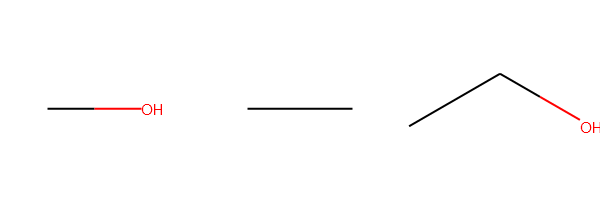

In [12]:
submols = []
for bit, atom_radius in bitinfo.items():
    atom, radius = atom_radius[0]
    if radius == 0: # radius 0 means just the atom, not useful as path
        continue
    hit_atoms = Chem.FindAtomEnvironmentOfRadiusN(ethanol, radius, atom)
    submols.append(Chem.PathToSubmol(ethanol, hit_atoms))
print([i for i in hit_atoms])
Draw.MolsToGridImage(submols)

Yeah, pretty much Ethanol :) Using this functionality, let's write a generic function that gets a Mol instance and a bit number, and spits out which fragments were responsible for that bit to be set in that particular molecule:

In [13]:
def substructures_of_bit_ecfp4_1024(mol, bit):
    bitinfo = {}
    Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024, bitInfo=bitinfo)
    
    submols = []
    for atom_radius in bitinfo.get(bit, []):
        atom, radius = atom_radius
        if radius == 0: # radius 0 means just the atom, not useful as path
            continue
        hit_atoms = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom)
        submols.append(Chem.PathToSubmol(mol, hit_atoms))
    return submols

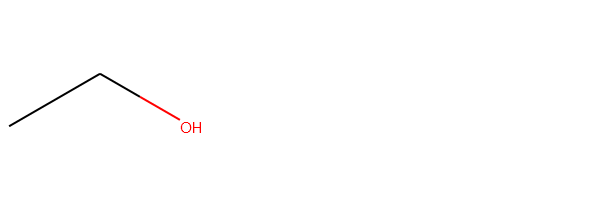

In [14]:
# test the func :)
Draw.MolsToGridImage(substructures_of_bit_ecfp4_1024(ethanol, 386))

Ok, seems to work... let's find out which substructures are responsible for the comparatively frequent bit 650 among DRD1 ligands. You do the most comparatively frequent bit for your ligand set, on your ligand set :)

## mTOR and drugbank - bit 378

In [17]:
substructure_smiles_db = {}
for drug in drugs:
    for submol in substructures_of_bit_ecfp4_1024(drug, 378):
        subsmiles = Chem.MolToSmiles(submol)
        substructure_smiles_db[subsmiles] = substructure_smiles_db.get(subsmiles, 0) + 1
substructure_smiles_db =  {k: v for k, v in sorted(substructure_smiles_db.items(), key=lambda item: item[1], reverse=True)}
len(substructure_smiles_db), substructure_smiles_db

(35,
 {'ccc(Cl)c(c)Cl': 13,
  'cc(c)[O-]': 6,
  'ccn(c(c)c)C(C)C': 5,
  'CC[NH3+]': 5,
  'cc(c)[C@@H](Cc)[N+](C)(C)C': 4,
  'C=C(C)C': 4,
  '[NH3+]CO': 3,
  'C[C@@H](N)[C@@H](C)O': 2,
  'cc(c)[C@@H](O)CN': 2,
  'cc(c)C(Cc)[N+](C)(C)C': 2,
  'C[C@@H](N)CCS': 2,
  'ccc(cc)C[NH3+]': 2,
  'C[C@H](N)[C@@H](C)O': 2,
  'cc(C)c(c(c)C)c(c)c': 2,
  'CCC(NC)C(C)=O': 2,
  'CCNC(c)C': 1,
  'COC(=O)CS': 1,
  'ccc(NS)c(c)-c': 1,
  'ccc(sc)C(C)(C)N': 1,
  'C=C(S)C[C@H](C)N': 1,
  'C=CC[C@@H](C)O': 1,
  'CC[C@@H](NC)C(C)=O': 1,
  'CC(C)NC(C)c': 1,
  'CC(C)(C)SCN': 1,
  'ccn(nc)C(C)C': 1,
  'CC(=O)CC(=O)S': 1,
  'ccc(C(=O)O)c(c)S': 1,
  'cc(o)Cl': 1,
  'C[C@H](O)C[P@H](=O)[O-]': 1,
  'Cc(n)[nH]c([nH])=S': 1,
  'ccnc(n)N': 1,
  'ccc(cc)[C@@H](N)S': 1,
  'CN(C)C(=O)N(C)C': 1,
  'cn(c)O': 1,
  'CCNC(C)c': 1})

Po uprave funkce substructures_of_bit_ecfp4_1024 u mTOR najednou 3686 namísto 50 substruktur. Chyba??

In [18]:
substructure_smiles = {}
for ligand in mtor_ligands:
    for submol in substructures_of_bit_ecfp4_1024(ligand, 378):
        subsmiles = Chem.MolToSmiles(submol)
        substructure_smiles[subsmiles] = substructure_smiles.get(subsmiles, 0) + 1
len(substructure_smiles), substructure_smiles

(3, {'ccnc(n)N': 4, 'cc(-c)cc(-c)n': 1, 'ccc(Cl)c(c)Cl': 1})

## DRD1 and drugbank - bit 650

In [15]:
substructure_smiles = {}
for ligand in drd1_ligands:
    for submol in substructures_of_bit_ecfp4_1024(ligand, 650):
        subsmiles = Chem.MolToSmiles(submol)
        substructure_smiles[subsmiles] = substructure_smiles.get(subsmiles, 0) + 1
#sort by value before displaying
substructure_smiles =  {k: v for k, v in sorted(substructure_smiles.items(), key=lambda item: item[1], reverse=True)}
len(substructure_smiles), substructure_smiles 

(6,
 {'cc(c)CC': 9,
  'cnc(c(c)c)n(c)-c': 2,
  'CO[C@H](C)C': 2,
  'cc(c)CC(=O)O': 2,
  'cc(N)cc(c)Cl': 1,
  'ccc(cn)-c(c)n': 1})

Quite a few fragments seem to map onto 650 among DRD1 ligands, most notably cc, cc(c)C and CCC. Let's have a look what's most prevalent in DrugBank for this bit:

In [16]:
substructure_smiles_db = {}
for drug in drugs:
    for submol in substructures_of_bit_ecfp4_1024(drug, 650):
        subsmiles = Chem.MolToSmiles(submol)
        substructure_smiles_db[subsmiles] = substructure_smiles_db.get(subsmiles, 0) + 1
substructure_smiles_db =  {k: v for k, v in sorted(substructure_smiles_db.items(), key=lambda item: item[1], reverse=True)}
len(substructure_smiles_db), substructure_smiles_db

(37,
 {'cc(c)C(N)=[NH2+]': 20,
  'cc(c)CC': 14,
  'cc(c)CC(=O)O': 11,
  'COC(C)C': 10,
  'ccc(cn)-c(c)n': 7,
  'cc(C)[nH]': 7,
  'cc(N)cc(c)Cl': 6,
  'CCCN(C)C': 6,
  'ccc(cn)c(c)n': 4,
  'cnc(c(c)c)n(c)-c': 2,
  'C[C@@H](N)CCN': 2,
  'CC(O)=NC(C)C': 2,
  'cc(C)cc(c)C': 2,
  'CC(=O)CC(C)C': 2,
  'cc(S)cc(c)c': 2,
  'cc(-n)cc(c)Cl': 2,
  'cc(O)c(c([nH])=O)C(C)C': 2,
  'nc(n)N': 2,
  'CNNC(N)=O': 1,
  'CCN(C)Cc': 1,
  'CC([C@@H](C)O)[C@@H](C)O': 1,
  'CCC(Cc)(NC)C(C)=O': 1,
  'CCC(C)(C)C(C)=O': 1,
  'cc(n)N(CN)[C@@H](C)O': 1,
  'CC(=O)N=C(C)c': 1,
  'PC[AsH]': 1,
  'CCNC(C)=[NH2+]': 1,
  'O=[V](=O)(O)O': 1,
  'O=C(O)[C@@H](O)CO': 1,
  'CCC(CC)[C@H](C)O': 1,
  'C=C(C)C(=O)OC': 1,
  'CCCF': 1,
  'cc(C)c(C)c(C)[nH]': 1,
  'C[C@H](O)CC(C)(C)C': 1,
  'cn(c)CCc': 1,
  'CO[P@](=O)(O)[C@H](C)N': 1,
  'cc(C)cn(c)C': 1})

TODO 
So, in DrugBank, the fragment present most often behind this bit is 'ccc', i.e. 3 aromatic carbons, ncN, cnc, ccC and many other fragments, in relatively small amounts. The most frequent fragments in DrugBank mapping to 378 seem mostly related to rings, often aromatic/heterocyclic. In comparison, the most frequent fragments mapping to 378 seem to be COc, CCC, CCc, CNC, CCN, COC, etc. Those most common in DrugBank also appear there, but are comparatively less prominent. Therefore, the higher prevalence of bit 378 in MTOR ligands may be at least partially caused by higher amount of these aliphatic, or at least non-aromatic fragments amongst MTOR ligands.